In [397]:
import email
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score


def parse_email(file_path):
    """
    Read each open in the directory & parse email info
    Path: Variable used to define folder location
    """
    with open(file_path, 'rb') as f:
        msg = email.message_from_bytes(f.read())
        
    #Get email headers
    subject = msg.get('Subject')
    
    # Read email’s body
    body = str(msg.get_payload())
    
    # Remove HTML tags
    body = BeautifulSoup(body).get_text()
    return subject, body

In [398]:
def confusion_matrix_plot(conf_mat):
    n = len(conf_mat)
    plt.imshow(conf_mat, cmap='Blues', extent=[-0.5, n-0.5, -0.5, n-0.5])
    
    for i in range(n):
        for j in range(n):
            plt.text(i, j, conf_mat[n-j-1, i], ha='center', va='center')
    
    plt.colorbar()
    plt.xticks(range(n))
    plt.yticks(range(n), range(n-1, -1, -1))
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.plot

In [420]:
def plot_learning_curve(test_error, training_size):
    plt.plot(training_size, test_error)
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Test Accuracy")
    plt.plot

In [400]:
ham_path = "/Users/colecrescas/Downloads/easy_ham"
spam_path = "/Users/colecrescas/Downloads/spam"

ham = []
spam = []

def email_to_dataframe(dir_path, lst):
    for file in os.listdir(dir_path):
        file_path = f"{dir_path}/{file}"
        X = parse_email(file_path)
        #text = re.sub('http://\S+|https://\S+', '', X)
        lst.append(X)

email_to_dataframe(ham_path, ham)
email_to_dataframe(spam_path, spam)

ham_0 = pd.Series(np.zeros(len(ham)))
spam_1 = pd.Series(np.ones(len(spam)))

df1 = pd.DataFrame()
df1['email'] = ham
df1['Spam (1) or ham (0)'] = ham_0

df2 = pd.DataFrame()
df2['email'] = spam
df2['Spam (1) or ham (0)'] = spam_1

df = df1.append(df2, ignore_index=True)
df['email'] = df['email'].astype(str)
df["Spam (1) or ham (0)"].astype(int)
df['email'] = df['email'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL')

/Users/colecrescas/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [410]:
tf_idf = TfidfVectorizer(stop_words='english')

bow = tf_idf.fit_transform(df['email']).toarray()

vect = pd.DataFrame(bow, columns=tf_idf.get_feature_names())
vect["Spam (1) or ham (0)"] = df["Spam (1) or ham (0)"]

In [411]:
X_train, X_test, y_train, y_test = train_test_split(vect.iloc[:,:-1], vect['Spam (1) or ham (0)'], test_size = 0.25)

Classifiers tried: KNN, SGDClassifier, MultinomialNB, Logistic Regression

MultinomialNB had a very high precision but the recall was poor on both the training & test set.  The accuracy on the training & test sets was 87.8% & 85.8% respectively.

Logistic Regression also had a very high precision but the recall was still low.  The recall was better than the MultinomialNB performance and the accuracy on the training & test sets was 69.8 % & 59.6% respectively.

KNN had a mediocre performance overall with precision levels around 47% for both sets as well as an accuracy score of around 81.5%.  In addition, the computation time was far too long to iterate on the model (selecting a n_neighbors value of 3).

SGDClassifier had a fantastic performance on the training set & a test set but the recall on the test set was significantly less than the recall on the training set.  Both sets had a high accuracy score shown in the table belo

In [412]:
clf = SGDClassifier()

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_pred_train)
conf_mat_test = confusion_matrix(y_test, y_pred_test)

results = pd.DataFrame(index = None)
results['Metric'] = ['Precision', 'Recall', 'Accuracy']
results['Classifier Train'] = [(precision_score(y_train, y_pred_train)), (recall_score(y_train, y_pred_train)), (clf.score(X_train, y_train))]
results['Classifier Test'] = [(precision_score(y_test, y_pred_test)), (recall_score(y_test, y_pred_test)), (clf.score(X_test, y_test))]

print(results.to_string(index=False))

    Metric  Classifier Train  Classifier Test
 Precision          1.000000         1.000000
    Recall          0.989362         0.824000
  Accuracy          0.998223         0.970706


Train Confusion Matrix:


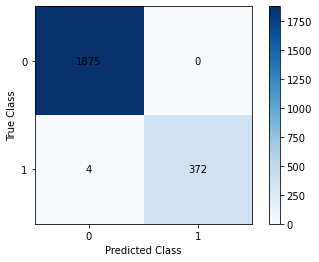

In [413]:
print("Train Confusion Matrix:")
confusion_matrix_plot(conf_mat_train)

Test Confusion Matrix:


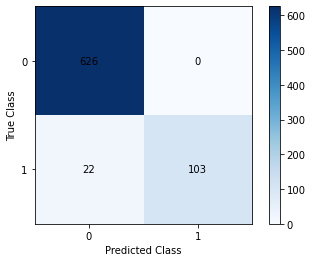

In [414]:
print("Test Confusion Matrix:")
confusion_matrix_plot(conf_mat_test)

In [421]:
test_accuracy = []
training_size = []
train_size=0.3

for i in range(17):
    X_train, X_test, y_train, y_test = train_test_split(vect.iloc[:,:-1], vect['Spam (1) or ham (0)'], train_size = train_size)

    clf = SGDClassifier()
    
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    test_accuracy.append(round(clf.score(X_test, y_test), 3))
    training_size.append(round(train_size, 3))
    
    train_size += 0.025

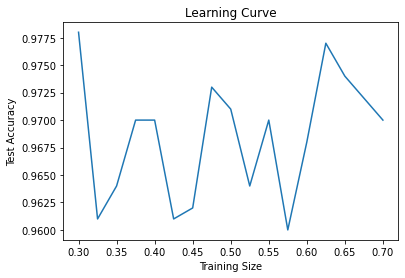

In [422]:
plot_learning_curve(test_accuracy, training_size)

Using the learning curve graph shown above it is clear that there isnt a large difference in performance other than the training size input of 0.3.  However, by selecting the max value of the test accuracy we can tune our model parameters and optimize the performance.

In [423]:
#redo calculations using best value of training size
test_size = (1 - max(test_accuracy))
X_train2, X_test2, y_train2, y_test2 = train_test_split(vect.iloc[:,:-1], vect['Spam (1) or ham (0)'], test_size = test_size)

In [424]:
clf.fit(X_train2, y_train2)
y_pred_train2 = clf.predict(X_train2)
y_pred_test2 = clf.predict(X_test2)

results2 = pd.DataFrame(index = None)
results2['Metric'] = ['Precision', 'Recall', 'Accuracy']
results2['Classifier Train'] = [(precision_score(y_train2, y_pred_train2)), (recall_score(y_train2, y_pred_train2)), (clf.score(X_train2, y_train2))]
results2['Classifier Test'] = [(precision_score(y_test2, y_pred_test2)), (recall_score(y_test2, y_pred_test2)), (clf.score(X_test2, y_test2))]

print("Test Size = 0.25")
print(results2.to_string(index=False), "\n")
print("Selected Best Test Size =", round(test_size, 2))
print(results.to_string(index=False))

Test Size = 0.25
    Metric  Classifier Train  Classifier Test
 Precision          1.000000         1.000000
    Recall          0.991803         0.923077
  Accuracy          0.998637         0.985075 

Selected Best Test Size = 0.02
    Metric  Classifier Train  Classifier Test
 Precision          1.000000         1.000000
    Recall          0.989362         0.824000
  Accuracy          0.998223         0.970706


In [425]:
ham_df = vect.iloc[:501,:]
spam_df = vect.iloc[502:,:]
prob = pd.DataFrame()
token = []
ham_prob = []
spam_prob = []

for columnName in ham_df.iloc[:,:-1]:
    ham_prob.append(np.count_nonzero(ham_df[columnName]) / 501)
    token.append(columnName)

for columnName in spam_df.iloc[:,:-1]:
    spam_prob.append(np.count_nonzero(spam_df[columnName]) / 2501)  

prob['Ham_Prob'] = ham_prob
prob['Spam_Prob'] = spam_prob
prob['Token'] = token
prob['log token value'] = np.log(prob['Spam_Prob'] / prob['Ham_Prob'])
prob.replace([np.inf, -np.inf], np.nan, inplace=True)
prob.dropna(inplace=True)

top_5_tokens = prob.nlargest(5, 'log token value')
print(top_5_tokens)

       Ham_Prob  Spam_Prob    Token  log token value
49787  0.001996   0.042383      xa0         3.055599
34787  0.001996   0.033187  nplease         2.811001
38416  0.001996   0.021991      opt         2.399493
39837  0.001996   0.019192     plus         2.263361
27868  0.003992   0.034386       n1         2.153360


/Users/colecrescas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
